In [1]:
import sys
sys.path.append('../../')
from Backtest import Backtest,Position,Bid
import pandas as pd
import matplotlib.pyplot as plt
import random
import warnings
import pickle
import yfinance as yf
#warnings.filterwarnings("ignore")

# Bid Class Demo
## intialize a Bid instance with four variables
- ticker
- shares
- price
- bid_type (1 as buy, 0 as sell)


In [2]:
# a bid to buy 100 shares of Apple at $163.43
buy_apple_100 = Bid(ticker = "AAPL", shares = 100, price = 163.43, bid_type = 1)

#the show method could be used for debugging
buy_apple_100.show()

---------------
Buying:
Ticker: AAPL
Shares: 100
Price: 163.43
---------------


# 

# Position class demo
## intialize a Position  instance with a bid instance

In [3]:
apple_position = Position(buy_apple_100)
apple_position.show()

Ticker: AAPL
Shares_held: 100
Latest_price: 163.43
weighted_average_cost: 163.43
----------------
Purchasing History
Price	Shares
163.43	100


## Change the position with another bid

In [4]:
buy_apple_50 = Bid(ticker = "AAPL", shares = 50, price = 163.13, bid_type = 1)
apple_position.change_position(buy_apple_50)
apple_position.show()

Ticker: AAPL
Shares_held: 150
Latest_price: 163.13
weighted_average_cost: 163.33
----------------
Purchasing History
Price	Shares
163.43	100
163.13	50


## Selling a stock

In [5]:
sell_apple_100 = Bid(ticker = 'AAPL', shares = 100, price = 165.24, bid_type = 0)

#if selling a stock, the change_position method will return a cost
#this cost will be the lowest part of costs in purchasing history 
cost_of_buying_100 = apple_position.change_position(sell_apple_100)
apple_position.show()

Ticker: AAPL
Shares_held: 50
Latest_price: 165.24
weighted_average_cost: 163.43
----------------
Purchasing History
Price	Shares
163.43	50


In [6]:
income = sell_apple_100.shares * sell_apple_100.price
print("Income: ", income)
print("Cost: ", cost_of_buying_100)
print("Pnl for this single trade: ", income - cost_of_buying_100 )

Income:  16524.0
Cost:  16328.0
Pnl for this single trade:  196.0


In [7]:
apple_position.change_position(sell_apple_100)

Try to sell 100 shares, but only got 50 shares.


0

# A demo strategy
## Randomly buy 10 stocks every Monday and sell on Friday
## a strategy is defined as a class, and it must have a predict method that returns a list of Bid instances
## a strategy function has five parameters, which are:
- ti: current datetime 
- df: all historical data up to ti
- positions: a dictionary of all current positions (k: string of ticker, v: an instance of this ticker's Position)
- cash: cash avaliable
- full_data: dataframe with OHLCV

## *This is the part where you implement your strategy

In [17]:
class DemoStrategy:
    
    def predict(ti,df,positions,cash,full_data):
#         if ti.minute == 0 or ti.minute == 30:
#             print("================={}=================".format(ti))
        bid_list = []

        #buy
        if ti.weekday() == 0:
            for ticker in ['GOOG','TSLA','AMZN','AAPL','MMM']:
                price = df.iloc[-1][ticker]
                shares = cash/5//price
                bid = Bid(ticker = ticker, shares = shares, price = df.iloc[-1][ticker],bid_type = 1)
                bid.show()
                bid_list.append(bid)
                #bid.show()

        #sell
        if ti.weekday() == 4:
            #for all current positions
            for pos in positions.values():
                
                bid = Bid(ticker = pos.ticker,shares = pos.shares,price = df.iloc[-1][pos.ticker],bid_type = 0)
                
                bid_list.append(bid)
                bid.show()
            
        return bid_list

# Load sample data

In [18]:
def get_data(tickers,length,interval):
    data =  yf.download(tickers = tickers, 
    period = length, interval = interval, group_by = 'ticker',
    auto_adjust = True,
    prepost = False,
    threads = True,
    proxy = None
)

    data = data.loc[:, pd.IndexSlice[:, ['Close']]]

    columns = data.columns.droplevel(1)

    data.columns = columns 

    data.sort_index(axis = 1, inplace = True)
    #data = data.reset_index(drop = True)
    return data.dropna()

In [19]:
with open("sp100tickers.pickle", "rb") as f:
            tickers = pickle.load(f)
        
#data = get_data(tickers,'1440d','1d')
#data.to_csv("test_data.csv",index = True)
data = pd.read_csv("test_Data.csv",index_col = 0)
data.index = pd.to_datetime(data.index)

# Backtest Demo
## initialize a Backtest instance with data and strategy, in default:
- initial_amount = 100000
- has_tc = True (0.2% of transaction cost)

In [20]:
random_strat = Backtest(data, DemoStrategy, has_tc = False)

In [21]:
random_strat.backtest_full()

---------------
Buying:
Ticker: GOOG
Shares: 335.0
Price: 59.650001525878906
---------------
---------------
Buying:
Ticker: TSLA
Shares: 1151.0
Price: 17.3613338470459
---------------
---------------
Buying:
Ticker: AMZN
Shares: 225.0
Price: 88.71299743652344
---------------
---------------
Buying:
Ticker: AAPL
Shares: 436.0
Price: 45.8130111694336
---------------
---------------
Buying:
Ticker: MMM
Shares: 111.0
Price: 179.5221710205078
---------------
---------------
Selling
Ticker: GOOG
Shares: 335.0
Price: 58.66550064086914
---------------
---------------
Selling
Ticker: TSLA
Shares: 1151.0
Price: 18.65733337402344
---------------
---------------
Selling
Ticker: AMZN
Shares: 225.0
Price: 89.0374984741211
---------------
---------------
Selling
Ticker: AAPL
Shares: 436.0
Price: 46.106712341308594
---------------
---------------
Selling
Ticker: MMM
Shares: 111.0
Price: 183.5594787597656
---------------
---------------
Buying:
Ticker: GOOG
Shares: 340.0
Price: 59.72150039672852
-----

---------------
Selling
Ticker: GOOG
Shares: 370.0
Price: 54.26750183105469
---------------
---------------
Selling
Ticker: TSLA
Shares: 1411.0
Price: 14.32800006866455
---------------
---------------
Selling
Ticker: AMZN
Shares: 215.0
Price: 93.4834976196289
---------------
---------------
Selling
Ticker: AAPL
Shares: 426.0
Price: 46.96409225463867
---------------
---------------
Selling
Ticker: MMM
Shares: 133.0
Price: 148.51919555664062
---------------
---------------
Buying:
Ticker: GOOG
Shares: 367.0
Price: 54.625
---------------
---------------
Buying:
Ticker: TSLA
Shares: 1338.0
Price: 15.001999855041504
---------------
---------------
Buying:
Ticker: AMZN
Shares: 212.0
Price: 94.30149841308594
---------------
---------------
Buying:
Ticker: AAPL
Shares: 424.0
Price: 47.24430465698242
---------------
---------------
Buying:
Ticker: MMM
Shares: 135.0
Price: 148.59938049316406
---------------
---------------
Selling
Ticker: GOOG
Shares: 367.0
Price: 56.09400177001953
-------------

---------------
Selling
Ticker: GOOG
Shares: 346.0
Price: 57.56449890136719
---------------
---------------
Selling
Ticker: TSLA
Shares: 1371.0
Price: 14.09333324432373
---------------
---------------
Selling
Ticker: AMZN
Shares: 228.0
Price: 87.48100280761719
---------------
---------------
Selling
Ticker: AAPL
Shares: 403.0
Price: 49.56399154663086
---------------
---------------
Selling
Ticker: MMM
Shares: 141.0
Price: 140.13148498535156
---------------
---------------
Buying:
Ticker: GOOG
Shares: 338.0
Price: 58.44449996948242
---------------
---------------
Buying:
Ticker: TSLA
Shares: 1381.0
Price: 14.333333015441896
---------------
---------------
Buying:
Ticker: AMZN
Shares: 223.0
Price: 88.44349670410156
---------------
---------------
Buying:
Ticker: AAPL
Shares: 392.0
Price: 50.50566482543945
---------------
---------------
Buying:
Ticker: MMM
Shares: 141.0
Price: 140.37425231933594
---------------
---------------
Selling
Ticker: GOOG
Shares: 338.0
Price: 59.40499877929688
-

Ticker: AAPL
Shares: 363.0
Price: 62.57136535644531
---------------
---------------
Selling
Ticker: MMM
Shares: 145.0
Price: 152.935302734375
---------------
---------------
Buying:
Ticker: GOOG
Shares: 342.0
Price: 64.56849670410156
---------------
---------------
Buying:
Ticker: TSLA
Shares: 1044.0
Price: 21.1646671295166
---------------
---------------
Buying:
Ticker: AMZN
Shares: 244.0
Price: 90.23300170898438
---------------
---------------
Buying:
Ticker: AAPL
Shares: 350.0
Price: 62.98226547241211
---------------
---------------
Buying:
Ticker: MMM
Shares: 140.0
Price: 157.26016235351562
---------------
---------------
Selling
Ticker: GOOG
Shares: 342.0
Price: 65.56849670410156
---------------
---------------
Selling
Ticker: TSLA
Shares: 1044.0
Price: 22.47599983215332
---------------
---------------
Selling
Ticker: AMZN
Shares: 244.0
Price: 89.29399871826172
---------------
---------------
Selling
Ticker: AAPL
Shares: 350.0
Price: 63.81901931762695
---------------
-------------

---------------
Selling
Ticker: GOOG
Shares: 349.0
Price: 71.48650360107422
---------------
---------------
Selling
Ticker: TSLA
Shares: 808.0
Price: 31.87666702270508
---------------
---------------
Selling
Ticker: AMZN
Shares: 255.0
Price: 94.15799713134766
---------------
---------------
Selling
Ticker: AAPL
Shares: 330.0
Price: 76.13191223144531
---------------
---------------
Selling
Ticker: MMM
Shares: 150.0
Price: 163.67323303222656
---------------
---------------
Buying:
Ticker: GOOG
Shares: 346.0
Price: 71.96150207519531
---------------
---------------
Buying:
Ticker: TSLA
Shares: 712.0
Price: 34.990665435791016
---------------
---------------
Buying:
Ticker: AMZN
Shares: 263.0
Price: 94.56500244140624
---------------
---------------
Buying:
Ticker: AAPL
Shares: 320.0
Price: 77.7584228515625
---------------
---------------
Buying:
Ticker: MMM
Shares: 151.0
Price: 164.08135986328125
---------------
---------------
Selling
Ticker: GOOG
Shares: 346.0
Price: 74.01950073242188
----

---------------
Selling
Ticker: GOOG
Shares: 429.0
Price: 55.53549957275391
---------------
---------------
Selling
Ticker: TSLA
Shares: 783.0
Price: 34.29066848754883
---------------
---------------
Selling
Ticker: AMZN
Shares: 238.0
Price: 95.00499725341795
---------------
---------------
Selling
Ticker: AAPL
Shares: 411.0
Price: 60.92122268676758
---------------
---------------
Selling
Ticker: MMM
Shares: 210.0
Price: 121.93333435058594
---------------
---------------
Buying:
Ticker: GOOG
Shares: 432.0
Price: 57.34099960327149
---------------
---------------
Buying:
Ticker: TSLA
Shares: 741.0
Price: 33.47533416748047
---------------
---------------
Buying:
Ticker: AMZN
Shares: 252.0
Price: 98.19750213623048
---------------
---------------
Buying:
Ticker: AAPL
Shares: 395.0
Price: 62.659793853759766
---------------
---------------
Buying:
Ticker: MMM
Shares: 196.0
Price: 126.05144500732422
---------------
---------------
Selling
Ticker: GOOG
Shares: 432.0
Price: 54.89400100708008
---

---------------
Buying:
Ticker: GOOG
Shares: 0.0
Price: 74.78500366210938
---------------
---------------
Buying:
Ticker: TSLA
Shares: 0.0
Price: 91.43866729736328
---------------
---------------
Buying:
Ticker: AMZN
Shares: 0.0
Price: 152.8520050048828
---------------
---------------
Buying:
Ticker: AAPL
Shares: 0.0
Price: 92.1815185546875
---------------
---------------
Buying:
Ticker: MMM
Shares: 0.0
Price: 146.1187286376953
---------------
---------------
Selling
Ticker: GOOG
Shares: 397.0
Price: 77.08699798583984
---------------
---------------
Selling
Ticker: TSLA
Shares: 411.0
Price: 102.97666931152344
---------------
---------------
Selling
Ticker: AMZN
Shares: 206.0
Price: 160.0
---------------
---------------
Selling
Ticker: AAPL
Shares: 310.0
Price: 94.60535430908205
---------------
---------------
Selling
Ticker: MMM
Shares: 192.0
Price: 141.26658630371094
---------------
---------------
Buying:
Ticker: GOOG
Shares: 430.0
Price: 75.56700134277344
---------------
-----------

---------------
Selling
Ticker: GOOG
Shares: 445.0
Price: 72.9209976196289
---------------
---------------
Selling
Ticker: TSLA
Shares: 232.0
Price: 138.3633270263672
---------------
---------------
Selling
Ticker: AMZN
Shares: 205.0
Price: 156.25
---------------
---------------
Selling
Ticker: AAPL
Shares: 287.0
Price: 111.67196655273438
---------------
---------------
Selling
Ticker: MMM
Shares: 216.0
Price: 149.55650329589844
---------------
---------------
Buying:
Ticker: GOOG
Shares: 433.0
Price: 74.3010025024414
---------------
---------------
Buying:
Ticker: TSLA
Shares: 227.0
Price: 141.89332580566406
---------------
---------------
Buying:
Ticker: AMZN
Shares: 201.0
Price: 159.9600067138672
---------------
---------------
Buying:
Ticker: AAPL
Shares: 279.0
Price: 115.1104507446289
---------------
---------------
Buying:
Ticker: MMM
Shares: 212.0
Price: 151.7854461669922
---------------
---------------
Selling
Ticker: GOOG
Shares: 433.0
Price: 75.76100158691406
---------------


---------------
---------------
Buying:
Ticker: MMM
Shares: 232.0
Price: 160.05966186523438
---------------
---------------
Selling
Ticker: GOOG
Shares: 408.0
Price: 89.0885009765625
---------------
---------------
Selling
Ticker: TSLA
Shares: 173.0
Price: 203.3300018310547
---------------
---------------
Selling
Ticker: AMZN
Shares: 235.0
Price: 155.8209991455078
---------------
---------------
Selling
Ticker: AAPL
Shares: 303.0
Price: 121.15863800048828
---------------
---------------
Selling
Ticker: MMM
Shares: 232.0
Price: 163.70016479492188
---------------
---------------
Buying:
Ticker: GOOG
Shares: 416.0
Price: 88.00299835205078
---------------
---------------
Buying:
Ticker: TSLA
Shares: 171.0
Price: 213.27667236328125
---------------
---------------
Buying:
Ticker: AMZN
Shares: 232.0
Price: 157.84849548339844
---------------
---------------
Buying:
Ticker: AAPL
Shares: 304.0
Price: 120.53506469726562
---------------
---------------
Buying:
Ticker: MMM
Shares: 225.0
Price: 162.

Selling
Ticker: AAPL
Shares: 310.0
Price: 131.8370819091797
---------------
---------------
Selling
Ticker: MMM
Shares: 201.0
Price: 187.79296875
---------------
---------------
Buying:
Ticker: GOOG
Shares: 359.0
Price: 112.739501953125
---------------
---------------
Buying:
Ticker: TSLA
Shares: 173.0
Price: 233.9933319091797
---------------
---------------
Buying:
Ticker: AMZN
Shares: 240.0
Price: 168.96949768066406
---------------
---------------
Buying:
Ticker: AAPL
Shares: 311.0
Price: 130.0924530029297
---------------
---------------
Buying:
Ticker: MMM
Shares: 216.0
Price: 187.6317138671875
---------------
---------------
Selling
Ticker: GOOG
Shares: 359.0
Price: 114.88800048828124
---------------
---------------
Selling
Ticker: TSLA
Shares: 173.0
Price: 246.5933380126953
---------------
---------------
Selling
Ticker: AMZN
Shares: 240.0
Price: 169.9720001220703
---------------
---------------
Selling
Ticker: AAPL
Shares: 311.0
Price: 132.98695373535156
---------------
---------

---------------
Selling
Ticker: GOOG
Shares: 321.0
Price: 137.8159942626953
---------------
---------------
Selling
Ticker: TSLA
Shares: 193.0
Price: 214.4600067138672
---------------
---------------
Selling
Ticker: AMZN
Shares: 234.0
Price: 182.83200073242188
---------------
---------------
Selling
Ticker: AAPL
Shares: 294.0
Price: 147.51116943359375
---------------
---------------
Selling
Ticker: MMM
Shares: 220.0
Price: 191.5539093017578
---------------
---------------
Buying:
Ticker: GOOG
Shares: 306.0
Price: 139.64450073242188
---------------
---------------
Buying:
Ticker: TSLA
Shares: 195.0
Price: 219.2066650390625
---------------
---------------
Buying:
Ticker: AMZN
Shares: 231.0
Price: 184.99099731445312
---------------
---------------
Buying:
Ticker: AAPL
Shares: 289.0
Price: 147.93814086914062
---------------
---------------
Buying:
Ticker: MMM
Shares: 222.0
Price: 192.6813201904297
---------------
---------------
Selling
Ticker: GOOG
Shares: 306.0
Price: 135.2209930419922
-

---------------
Selling
Ticker: GOOG
Shares: 310.0
Price: 140.05599975585938
---------------
---------------
Selling
Ticker: TSLA
Shares: 159.0
Price: 261.8299865722656
---------------
---------------
Selling
Ticker: AMZN
Shares: 260.0
Price: 164.43099975585938
---------------
---------------
Selling
Ticker: AAPL
Shares: 299.0
Price: 142.10369873046875
---------------
---------------
Selling
Ticker: MMM
Shares: 244.0
Price: 170.35365295410156
---------------
---------------
Buying:
Ticker: GOOG
Shares: 305.0
Price: 138.84750366210938
---------------
---------------
Buying:
Ticker: TSLA
Shares: 160.0
Price: 263.9800109863281
---------------
---------------
Buying:
Ticker: AMZN
Shares: 261.0
Price: 162.31500244140625
---------------
---------------
Buying:
Ticker: AAPL
Shares: 298.0
Price: 142.0142059326172
---------------
---------------
Buying:
Ticker: MMM
Shares: 250.0
Price: 169.7086639404297
---------------
---------------
Selling
Ticker: GOOG
Shares: 305.0
Price: 141.6750030517578


---------------
Buying:
Ticker: GOOG
Shares: 0.0
Price: 148.06399536132812
---------------
---------------
Buying:
Ticker: TSLA
Shares: 0.0
Price: 364.6466674804688
---------------
---------------
Buying:
Ticker: AMZN
Shares: 0.0
Price: 169.66949462890625
---------------
---------------
Buying:
Ticker: AAPL
Shares: 0.0
Price: 179.5868682861328
---------------
---------------
Buying:
Ticker: MMM
Shares: 0.0
Price: 171.4973907470703
---------------
---------------
Selling
Ticker: GOOG
Shares: 314.0
Price: 144.67950439453125
---------------
---------------
Selling
Ticker: TSLA
Shares: 149.0
Price: 352.260009765625
---------------
---------------
Selling
Ticker: AMZN
Shares: 268.0
Price: 166.7169952392578
---------------
---------------
Selling
Ticker: AAPL
Shares: 265.0
Price: 176.83824157714844
---------------
---------------
Selling
Ticker: MMM
Shares: 267.0
Price: 172.4000244140625
---------------
---------------
Buying:
Ticker: GOOG
Shares: 325.0
Price: 145.07449340820312
------------

---------------
Selling
Ticker: GOOG
Shares: 326.0
Price: 134.010498046875
---------------
---------------
Selling
Ticker: TSLA
Shares: 122.0
Price: 341.8299865722656
---------------
---------------
Selling
Ticker: AMZN
Shares: 278.0
Price: 154.4604949951172
---------------
---------------
Selling
Ticker: AAPL
Shares: 263.0
Price: 169.6048583984375
---------------
---------------
Selling
Ticker: MMM
Shares: 319.0
Price: 146.8046112060547
---------------
---------------
Buying:
Ticker: GOOG
Shares: 339.0
Price: 129.79649353027344
---------------
---------------
Buying:
Ticker: TSLA
Shares: 135.0
Price: 325.3099975585937
---------------
---------------
Buying:
Ticker: AMZN
Shares: 291.0
Price: 151.1219940185547
---------------
---------------
Buying:
Ticker: AAPL
Shares: 266.0
Price: 165.27723693847656
---------------
---------------
Buying:
Ticker: MMM
Shares: 299.0
Price: 147.1083984375
---------------
---------------
Buying:
Ticker: GOOG
Shares: 0.0
Price: 127.96099853515624
---------

---------------
Buying:
Ticker: GOOG
Shares: 310.0
Price: 116.62249755859376
---------------
---------------
Buying:
Ticker: TSLA
Shares: 148.0
Price: 244.9199981689453
---------------
---------------
Buying:
Ticker: AMZN
Shares: 320.0
Price: 113.22000122070312
---------------
---------------
Buying:
Ticker: AAPL
Shares: 256.0
Price: 141.4635009765625
---------------
---------------
Buying:
Ticker: MMM
Shares: 275.0
Price: 131.4510040283203
---------------
---------------
Selling
Ticker: GOOG
Shares: 310.0
Price: 109.08100128173828
---------------
---------------
Selling
Ticker: TSLA
Shares: 148.0
Price: 227.26333618164065
---------------
---------------
Selling
Ticker: AMZN
Shares: 320.0
Price: 109.55999755859376
---------------
---------------
Selling
Ticker: AAPL
Shares: 256.0
Price: 138.73727416992188
---------------
---------------
Selling
Ticker: MMM
Shares: 275.0
Price: 127.18478393554688
---------------
---------------
Buying:
Ticker: GOOG
Shares: 297.0
Price: 116.5224990844726

---------------
Selling
Ticker: GOOG
Shares: 346.0
Price: 99.16999816894533
---------------
---------------
Selling
Ticker: TSLA
Shares: 116.0
Price: 275.3299865722656
---------------
---------------
Selling
Ticker: AMZN
Shares: 288.0
Price: 113.77999877929688
---------------
---------------
Selling
Ticker: AAPL
Shares: 232.0
Price: 150.42999267578125
---------------
---------------
Selling
Ticker: MMM
Shares: 308.0
Price: 112.98999786376952
---------------
---------------
Buying:
Ticker: GOOG
Shares: 342.0
Price: 98.80999755859376
---------------
---------------
Buying:
Ticker: TSLA
Shares: 122.0
Price: 276.010009765625
---------------
---------------
Buying:
Ticker: AMZN
Shares: 293.0
Price: 115.1500015258789
---------------
---------------
Buying:
Ticker: AAPL
Shares: 224.0
Price: 150.77000427246094
---------------
---------------
Buying:
Ticker: MMM
Shares: 299.0
Price: 113.0
---------------
---------------
Selling
Ticker: GOOG
Shares: 342.0
Price: 96.1500015258789
---------------


# After backtest, check all historical transactions with transaction_history, a dataframe that recorded each bid, its transaction cost and pnl.

In [22]:
random_strat.positions

{}

In [23]:
random_strat.transaction_history

,dt,ticker,type,price,shares,amount,cash_left,transaction_cost,pnl
0,2019-03-25,GOOG,1,59.650002,335.0,19982.750511,80017.249489,0.0,0.000000
1,2019-03-25,TSLA,1,17.361334,1151.0,19982.895258,60034.354231,0.0,0.000000
2,2019-03-25,AMZN,1,88.712997,225.0,19960.424423,40073.929808,0.0,0.000000
3,2019-03-25,AAPL,1,45.813011,436.0,19974.472870,20099.456938,0.0,0.000000
4,2019-03-25,MMM,1,179.522171,111.0,19926.960983,172.495955,0.0,0.000000
...,...,...,...,...,...,...,...,...,...
1635,2022-10-07,GOOG,0,99.570000,327.0,32559.389900,32794.920020,0.0,88.288902
1636,2022-10-07,TSLA,0,223.070007,134.0,29891.380981,62686.301002,0.0,-2590.218201
1637,2022-10-07,AMZN,0,114.559998,280.0,32076.799316,94763.100318,0.0,-369.599915
1638,2022-10-07,AAPL,0,140.089996,228.0,31940.519165,126703.619483,0.0,-538.080139


In [24]:
print("Total Transaction cost:", random_strat.transaction_history['transaction_cost'].sum())

Total Transaction cost: 0.0


<AxesSubplot:>

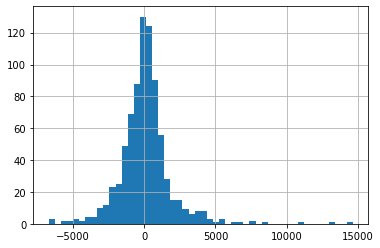

In [25]:
#histogram of pnl
random_strat.transaction_history[random_strat.transaction_history.type ==0]['pnl'].hist(bins = 50)

# The portfolio_tracker records the # of bids, length of positions, cash value, position value, total value at each ti. 
# The bah column is the value assuming we buy all the tickers when it begins

In [26]:
random_strat.portfolio_tracker

,dt,bid_count,position_count,cash_value,positions_value,total_value,bah
0,2019-03-20,0,0,100000.000000,0.000000,100000.000000,100000.000000
1,2019-03-21,0,0,100000.000000,0.000000,100000.000000,100954.473649
2,2019-03-22,0,0,100000.000000,0.000000,100000.000000,99110.452320
3,2019-03-25,5,5,172.495955,99827.504045,100000.000000,99028.807052
4,2019-03-26,0,5,172.495955,100546.818592,100719.314547,99948.807689
...,...,...,...,...,...,...,...
891,2022-09-30,5,0,162607.369185,0.000000,162607.369185,145482.006651
892,2022-10-03,5,5,235.530120,162371.839066,162607.369185,147742.010895
893,2022-10-04,0,5,235.530120,167311.972679,167547.502799,152403.253638
894,2022-10-05,0,5,235.530120,165993.467300,166228.997420,151698.105409


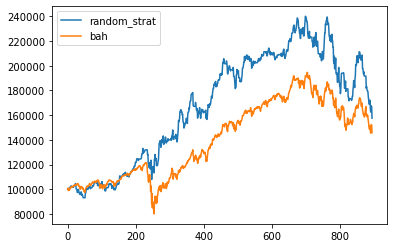

In [27]:
random_strat.plot()

In [19]:
len(data)

896

In [20]:
len(random_strat.portfolio_tracker)

897

# 

# Upload to dashboard
## the upload_to_dashboard method will upload this graph to dashboard.
## make sure the crediential file "algo-trade-dashboard-80cae071e907.json" is under current directory, also install the related packages in requirements.txt

## to upload, call the function with the strategy name, if the name already exist in the gcloud, the previous data will be overwritten

In [39]:
random_strat.upload_to_dashboard("random_demo_0912")

Data uploaded.


# Check on dashboard:
https://tigaji-algo-trade-dashboard-dashboard-gv8r0a.streamlitapp.com/